In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


## Parameters

In [ ]:
# Parameters for the American Put Option (using CRR model)
T = 1  # Time to maturity
S0 = 10  # Initial stock price
mu = 0.05
K = 10  # Strike price
r = 0.02  # Risk-free rate
sigma = 0.2  # Volatility
N = 5000  # Number of time steps (reduced to make plotting easier)
dt = T / N  # Time step size

# Binomial parameters
u = np.exp(sigma * np.sqrt(dt))  # Up factor
d = 1 / u  # Down factor
#p = 0.5*(1+((mu-r)-0.5*sigma**2)/sigma*np.sqrt(dt))  # Risk-neutral probability
p = 1/(1+np.exp(sigma*np.sqrt(dt)))  # Risk-neutral probability

## Exercise Boundary

In [ ]:
# Exercise Boundary
# Initialize the asset prices and option values
stock_prices = np.zeros((N + 1, N + 1))  # Store stock prices
option_values = np.zeros((N + 1, N + 1))  # Store option prices
exercise_boundary = np.full(N + 1,np.nan)  # To store the exercise boundary at each step

# Initialize matrices for early exercise and continuation values
early_exercise_matrix = np.zeros((N + 1, N + 1))
continuation_value_matrix = np.zeros((N + 1, N + 1))

def american_put_boundary(S_0, K, rf, sigma, dt, N):
  # Step 1: Stock prices at maturity (Step N)
  for i in range(N + 1):
      stock_prices[N, i] = S0 * (u ** i) * (d ** (N - i))*np.exp(r*T)

  # Step 2: Option values at maturity (American put payoff)
  option_values[N, :] = np.maximum(K - stock_prices[N, :], 0)

  # Step 3: Backward induction to calculate option values and exercise boundary
  for step in range(N - 1, -1, -1):
      for i in range(step + 1):
          stock_prices[step, i] = stock_prices[step + 1, i+1] / (u*np.exp(r*dt))  # Calculate stock price for this node
          #stock_prices[step, i] = S0 * (u ** i) * (d ** (step - i))
          # Calculate the continuation value
          continuation_value = np.exp(-r * dt) * (p * option_values[step + 1, i + 1] + (1 - p) * option_values[step + 1, i])
          # Early exercise value
          early_exercise_value = max(K - stock_prices[step, i],0)
          # Store in matrices
          early_exercise_matrix[step, i] = early_exercise_value
          continuation_value_matrix[step, i] = continuation_value

          # Take the maximum of holding or exercising early
          option_values[step, i] = np.maximum(continuation_value, early_exercise_value)

          # Store the exercise boundary at each step (where the option is exercised early)
          if continuation_value < early_exercise_value:
            exercise_boundary[step] = stock_prices[step, i]


  return exercise_boundary

exercise_boundary = american_put_boundary(S0, K, r, sigma, dt, N)

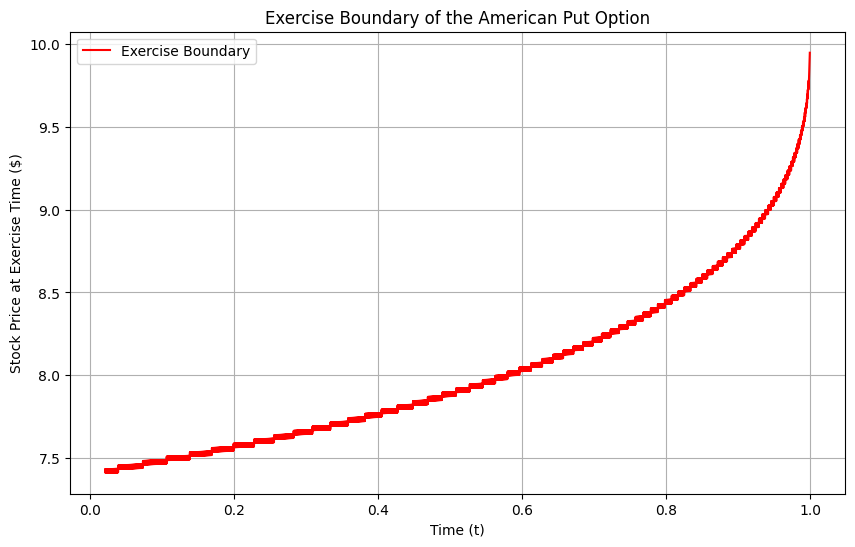

In [ ]:
# Plot the exercise boundary as a function of time
time_grid = np.linspace(0, T, N + 1)

plt.figure(figsize=(10, 6))
plt.plot(time_grid, exercise_boundary, label='Exercise Boundary', color='red')
plt.title('Exercise Boundary of the American Put Option')
plt.xlabel('Time (t)')
plt.ylabel('Stock Price at Exercise Time ($)')
plt.legend()
plt.grid(True)
plt.show()



## Sample Paths

In [ ]:
# Sample prices
# Function to generate a full path based on up and down movements

option_values[0,0]
def generate_path(start_price, step):
    path = [start_price]  # Start the path with the initial stock price
    for t in range(step, N):  # Continue from step to N
        movement = np.random.choice([u, d])  # Randomly pick an up or down movement
        next_price = path[-1] * movement  # Update the price based on the random movement
        path.append(next_price)
    return path

# Generate a sample path that triggers early exercise at t = 1/2
def generate_early_exercise_path():
    for step in range(1, N):  # Loop through the time steps
        current_stock_price = stock_prices[step, step]  # Move along the diagonal in the stock price tree
        early_exercise_value = max(K - current_stock_price, 0)
        continuation_value = option_values[step, step]

        # Trigger early exercise at t = 1/2 if the condition is met
        if step == N // 2 and early_exercise_value > continuation_value:
            pre_path = generate_path(S0, 1)  # Simulate path before early exercise (from t = 0 to t = 0.5)
            post_path = generate_path(current_stock_price, step)  # Simulate path after t = 0.5
            full_path = pre_path + post_path
            return full_path  # Return the full path with early exercise

    # In case no early exercise is triggered at t = 0.5, return a path for the whole period
    return generate_path(S0, 1)

# Generate a sample path that is never exercised early
def generate_no_exercise_path():
    path = [S0]  # Start with the initial stock price
    current_stock_price = S0

    for step in range(1, N):
        early_exercise_value = max(K - current_stock_price, 0)
        continuation_value = np.exp(-r * dt) * (p * option_values[step + 1, step + 1] + (1 - p) * option_values[step + 1, step])

        # Ensure that the next price keeps the path unexercisable
        if continuation_value > early_exercise_value:
            movement = np.random.choice([u, d])  # Randomly pick an up or down movement
            next_stock_price = current_stock_price * movement  # Update the price based on the random movement

            # Ensure the next stock price keeps it unexercisable
            next_early_exercise_value = max(K - next_stock_price, 0)
            next_continuation_value = np.exp(-r * dt) * (p * option_values[step + 1, step + 1] + (1 - p) * option_values[step + 1, step])

            # Only accept the movement if it keeps the path unexercisable
            if next_continuation_value > next_early_exercise_value:
                path.append(next_stock_price)
                current_stock_price = next_stock_price
            else:
                # If the movement would lead to early exercise, re-select an alternative path
                movement = d if movement == u else u  # Flip the movement direction
                next_stock_price = current_stock_price * movement
                path.append(next_stock_price)
                current_stock_price = next_stock_price

        else:
            # If early exercise condition is met (shouldn't happen), break (but this block shouldn't be reached)
            break

    return path

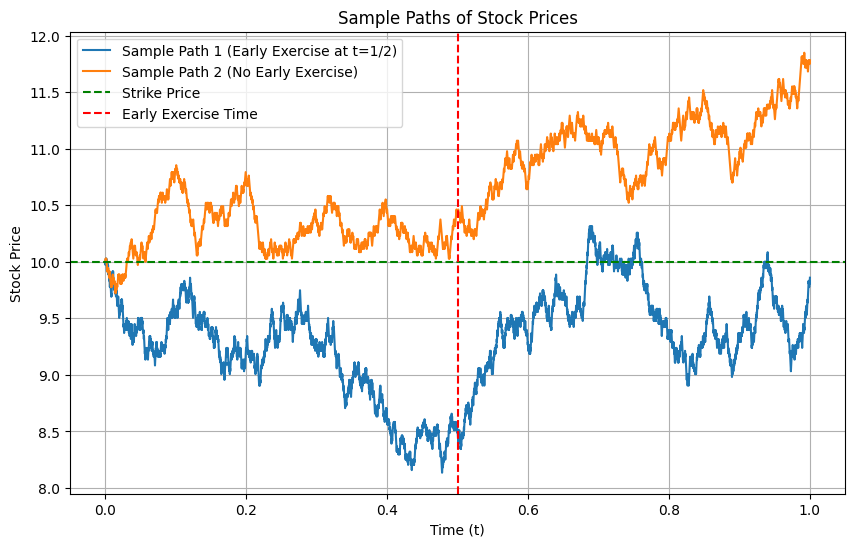

In [ ]:
# Generate the two sample paths
path_early = generate_early_exercise_path()
path_no_exercise = generate_no_exercise_path()

# Time grids based on the actual length of each path
time_grid_early = np.linspace(0, T, len(path_early))
time_grid_no_exercise = np.linspace(0, T, len(path_no_exercise))

# Plot the sample paths
plt.figure(figsize=(10, 6))
plt.plot(time_grid_early, path_early, label="Sample Path 1 (Early Exercise at t=1/2)")
plt.plot(time_grid_no_exercise, path_no_exercise, label="Sample Path 2 (No Early Exercise)")
plt.title("Sample Paths of Stock Prices")
plt.xlabel("Time (t)")
plt.ylabel("Stock Price")
plt.axhline(y=K, color='g', linestyle='--', label="Strike Price")
plt.axvline(x=T/2, color='r', linestyle='--', label="Early Exercise Time")
plt.legend()
plt.grid(True)
plt.show()

## Hedging

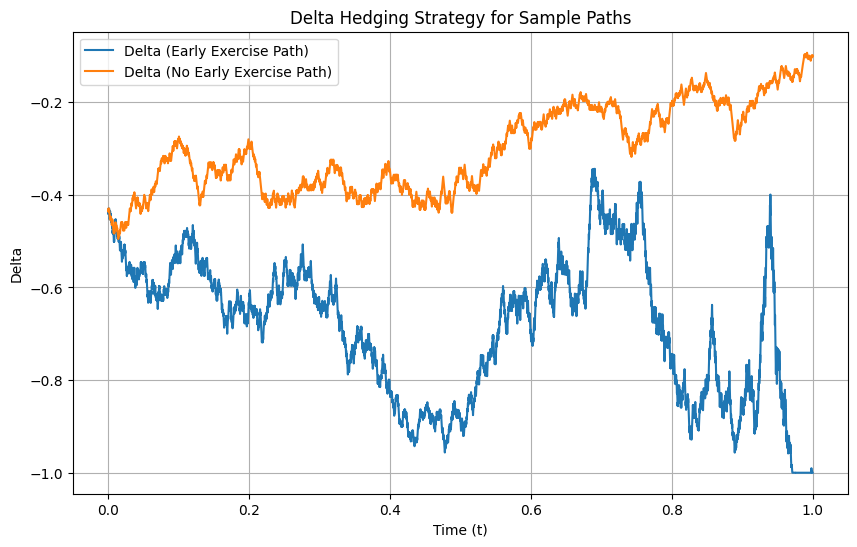

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Function to calculate delta for a given path by going backwards from N-1 to 0
def calculate_delta_backward(path, stock_prices, option_values, N):
    deltas = []

    # Loop backwards over the time steps from N-1 to 0
    for step in range(len(path) - 1, -1, -1):
        current_stock_price = path[step]  # Stock price at the current step

        # Find the index of the closest stock price in the binomial tree at this step
        differences = np.abs(stock_prices[step, :] - current_stock_price)
        current_node_index = np.argmin(differences)  # Get the index of the closest value

        # Get the up and down stock prices at the next time step
        S_up = stock_prices[step + 1, current_node_index + 1]  # Up movement
        S_down = stock_prices[step + 1, current_node_index]  # Down movement

        # Get the up and down option values at the next time step
        V_up = option_values[step + 1, current_node_index + 1]
        V_down = option_values[step + 1, current_node_index]

        # Calculate delta using the difference in option values and stock prices
        delta = (V_up - V_down) / (S_up - S_down)
        deltas.append(delta)

    # Return the deltas in reverse order so they correspond to the time steps in the path
    return deltas[::-1]  # Reverse the deltas list to match the correct time order

# Calculate delta for both early exercise and no-exercise paths
deltas_early = calculate_delta_backward(path_early, stock_prices, option_values, N)
deltas_no_exercise = calculate_delta_backward(path_no_exercise, stock_prices, option_values, N)

# Time grids for the delta plots (excluding the last step since delta can't be calculated there)
time_grid_deltas_early = np.linspace(0, T, len(deltas_early))
time_grid_deltas_no_exercise = np.linspace(0, T, len(deltas_no_exercise))

# Plot delta hedging strategy for the early exercise path
plt.figure(figsize=(10, 6))
plt.plot(time_grid_deltas_early, deltas_early, label="Delta (Early Exercise Path)")
plt.plot(time_grid_deltas_no_exercise, deltas_no_exercise, label="Delta (No Early Exercise Path)")
plt.title("Delta Hedging Strategy for Sample Paths")
plt.xlabel("Time (t)")
plt.ylabel("Delta")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
len(path_early)

5000

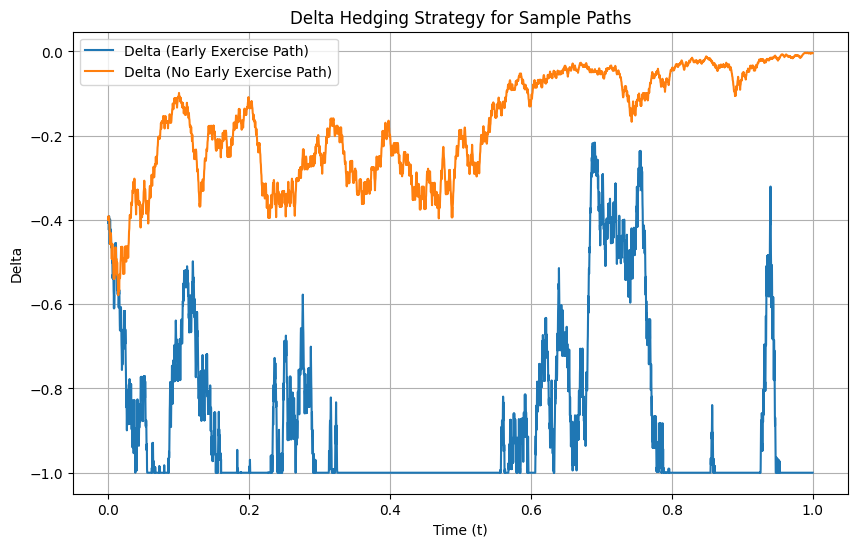

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Function to calculate delta for a given path by going backwards from len(path) - 2 to 0
def calculate_delta_backward(path, stock_prices, option_values):
    deltas = []
    N = len(path)  # Use the length of the actual path

    # Loop backwards over the time steps from len(path) - 2 to 0
    for step in range(N - 2, -1, -1):  # Adjust to ensure we don't go out of bounds
        current_stock_price = path[step]  # Stock price at the current step

        # Find the index of the closest stock price in the binomial tree at this step
        differences = np.abs(stock_prices[step, :] - current_stock_price)
        current_node_index = np.argmin(differences)  # Get the index of the closest value

        # Get the up and down stock prices at the next time step
        S_up = stock_prices[step + 1, current_node_index + 1]  # Up movement
        S_down = stock_prices[step + 1, current_node_index]  # Down movement

        # Get the up and down option values at the next time step
        V_up = option_values[step + 1, current_node_index + 1]
        V_down = option_values[step + 1, current_node_index]

        # Calculate delta using the difference in option values and stock prices
        delta = (V_up - V_down) / (S_up - S_down)
        deltas.append(delta)

    # Return the deltas in reverse order so they correspond to the time steps in the path
    return deltas[::-1]  # Reverse the deltas list to match the correct time order

# Generate the two sample paths as before
# Assuming path_early and path_no_exercise are generated earlier

# Calculate delta for both early exercise and no-exercise paths
deltas_early = calculate_delta_backward(path_early, stock_prices, option_values)
deltas_no_exercise = calculate_delta_backward(path_no_exercise, stock_prices, option_values)

# Time grids for the delta plots (excluding the last step since delta can't be calculated there)
time_grid_deltas_early = np.linspace(0, T, len(deltas_early))
time_grid_deltas_no_exercise = np.linspace(0, T, len(deltas_no_exercise))

# Plot delta hedging strategy for the early exercise path
plt.figure(figsize=(10, 6))
plt.plot(time_grid_deltas_early, deltas_early, label="Delta (Early Exercise Path)")
plt.plot(time_grid_deltas_no_exercise, deltas_no_exercise, label="Delta (No Early Exercise Path)")
plt.title("Delta Hedging Strategy for Sample Paths")
plt.xlabel("Time (t)")
plt.ylabel("Delta")
plt.legend()
plt.grid(True)
plt.show()


## Simulation

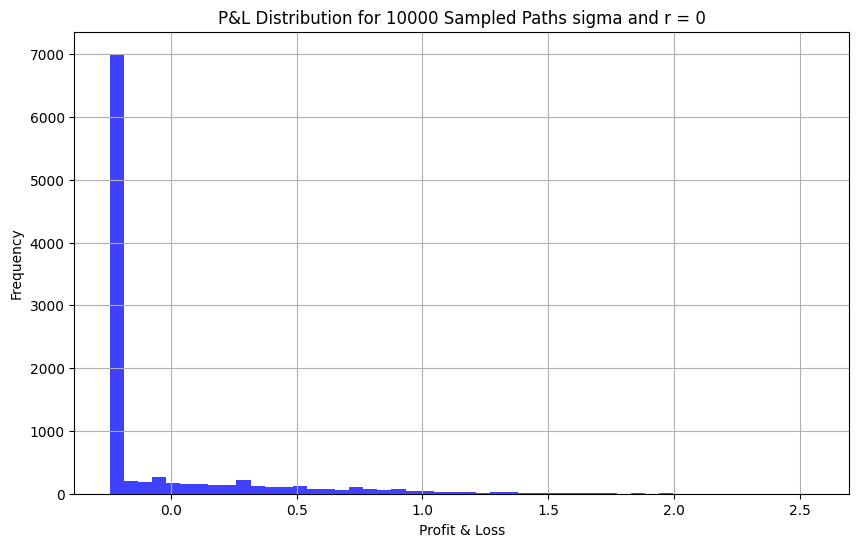

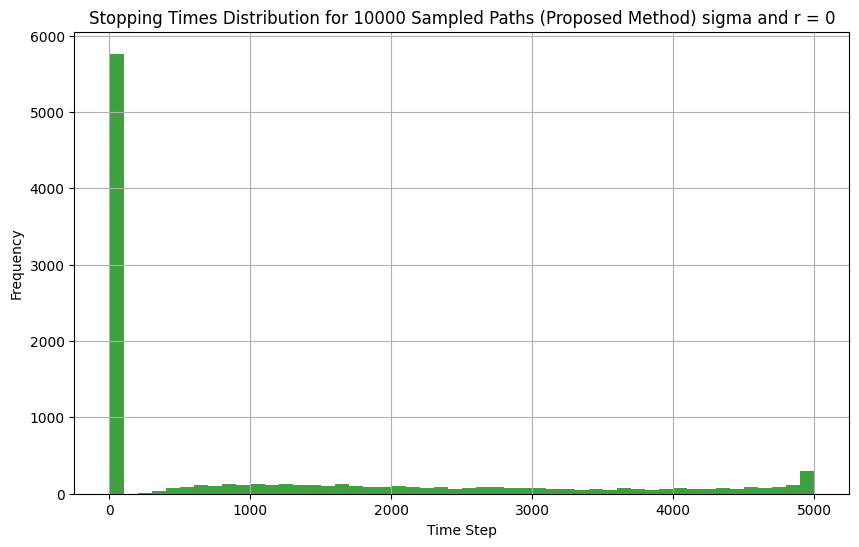

First few P&L values: [-0.24367782 -0.24367782 -0.24367782 -0.24367782 -0.24367782  0.26223576
 -0.24367782 -0.15470975 -0.20816719  0.63635181]
First few stopping times (proposed method): [   1  946    1    1    1 1086  912 4980 3445  431]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
T = 1  # Time to maturity
K = 10  # Strike price
r = 0.05  # Risk-free rate
M = 10000  # Number of sample paths
N = 5000  # Number of time steps in the binomial tree
dt = float(T / N)  # Time step size

# Function to calculate P&L for each sampled path
def calculate_pnl(sampled_paths, K, r, T, N):
    pnl = np.zeros(M)  # Array to store P&L

    for i in range(M):
        # Calculate P&L at maturity
        pnl[i] = max(K - sampled_paths[N, i], 0) * np.exp(-r * T) - option_values[0, 0]

    return pnl

def calculate_stopping_times_proposed_method(sampled_paths, sampled_continuation_values, K, dt):
    stopping_times = np.full(M, T)  # Default stopping time is T (no early exercise)

    for i in range(M):
        early_exercise_values = np.maximum(K - sampled_paths[:, i], 0)  # Calculate early exercise values

        # Subtract continuation values and find the first positive occurrence
        difference = early_exercise_values - sampled_continuation_values[:, i]
        positive_indices = np.where(difference > 0)[0]  # Find where early exercise occurs

        # Ensure that there is at least one positive index for early exercise
        if len(positive_indices) > 0:
            # Calculate the stopping time as a fraction of T based on the index in the time steps
            stopping_time_index = float(positive_indices[0])  # The first time step where early exercise happens
            stopping_times[i] = float(stopping_time_index)  # Convert index to actual time

    return stopping_times


# Function to sample valid paths through the binomial tree (as before)
def sample_binomial_tree_paths(stock_prices, continuation_value_matrix, M, N, p):
    sampled_paths = np.zeros((N + 1, M))
    sampled_continuation_values = np.zeros((N + 1, M))

    for i in range(M):  # For each sample path
        current_node = 0  # Start at the root (node 0 at step 0)
        for step in range(N + 1):
            # Record the stock price and continuation value at the current node
            sampled_paths[step, i] = stock_prices[step, current_node]
            sampled_continuation_values[step, i] = continuation_value_matrix[step, current_node]

            if step < N:
                # Randomly choose to go "up" or "down" at the next step using probability p
                move = np.random.choice([0, 1])  # 0 = down, 1 = up
                current_node += move  # Move to the next node

    return sampled_paths, sampled_continuation_values

# Simulate sampling paths from the binomial tree
sampled_paths, sampled_continuation_values = sample_binomial_tree_paths(stock_prices, continuation_value_matrix, M, N, p)

# Calculate P&L for the sampled paths
pnl = calculate_pnl(sampled_paths, K, r, T, N)

# Calculate stopping times using the proposed method
stopping_times_proposed = calculate_stopping_times_proposed_method(sampled_paths, sampled_continuation_values, K,dt)

# Plot the P&L distribution
plt.figure(figsize=(10, 6))
plt.hist(pnl, bins=50, alpha=0.75, color='blue')
plt.title(f"P&L Distribution for {M} Sampled Paths sigma=0.1 and r = 0.05")
plt.xlabel("Profit & Loss")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Plot the stopping times distribution using the proposed method
plt.figure(figsize=(10, 6))
plt.hist(stopping_times_proposed, bins=50, alpha=0.75, color='green')  # Stopping times should be between 0 and 1
plt.title(f"Stopping Times Distribution for {M} Sampled Paths (Proposed Method) sigma=0.1 and r = 0.05")
plt.xlabel("Time Step")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Print the first few stopping times and P&L values to check
print("First few P&L values:", pnl[:10])
print("First few stopping times (proposed method):", stopping_times_proposed[:10])


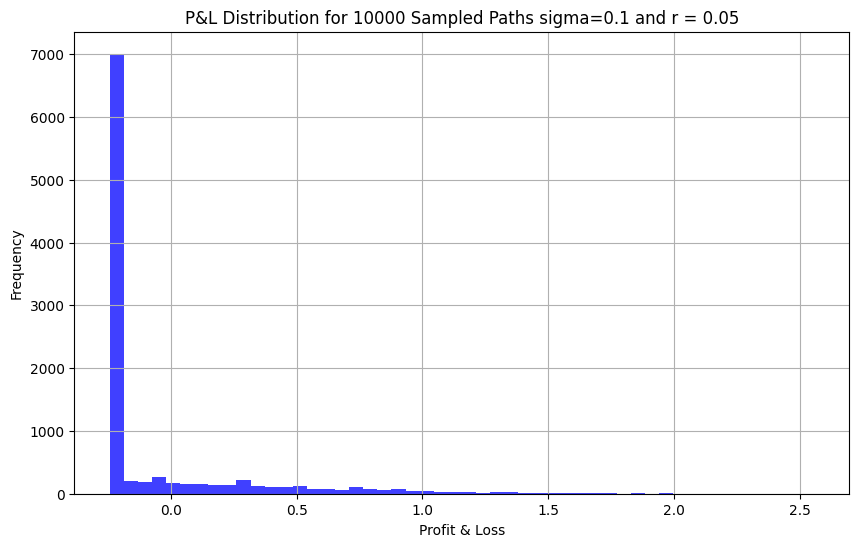

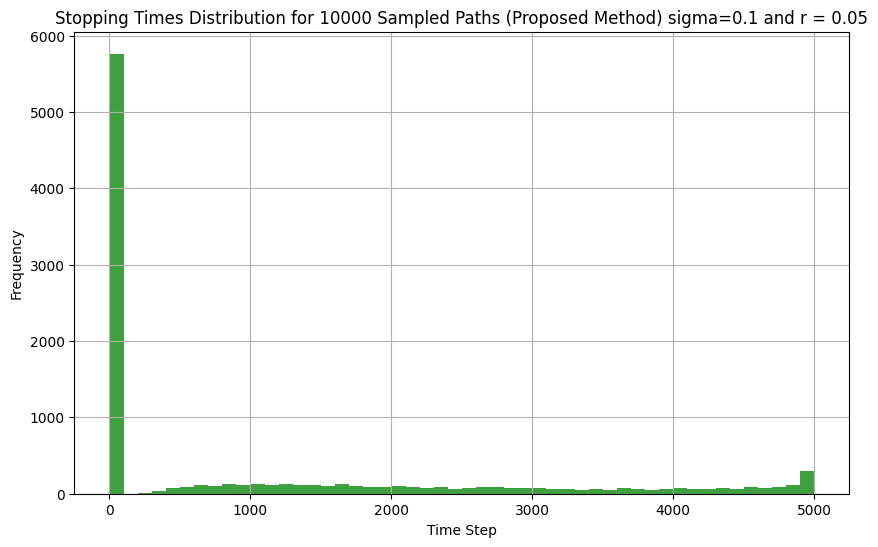

In [ ]:
# Plot the P&L distribution
plt.figure(figsize=(10, 6))
plt.hist(pnl, bins=50, alpha=0.75, color='blue')
plt.title(f"P&L Distribution for {M} Sampled Paths sigma=0.1 and r = 0.05")
plt.xlabel("Profit & Loss")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Plot the stopping times distribution using the proposed method
plt.figure(figsize=(10, 6))
plt.hist(stopping_times_proposed, bins=50, alpha=0.75, color='green')  # Stopping times should be between 0 and 1
plt.title(f"Stopping Times Distribution for {M} Sampled Paths (Proposed Method) sigma=0.1 and r = 0.05")
plt.xlabel("Time Step")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

### Different Vol

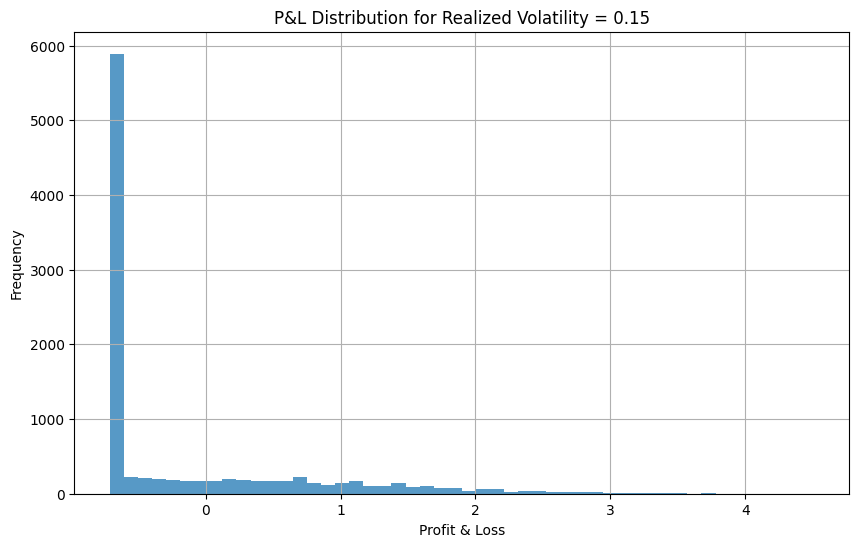

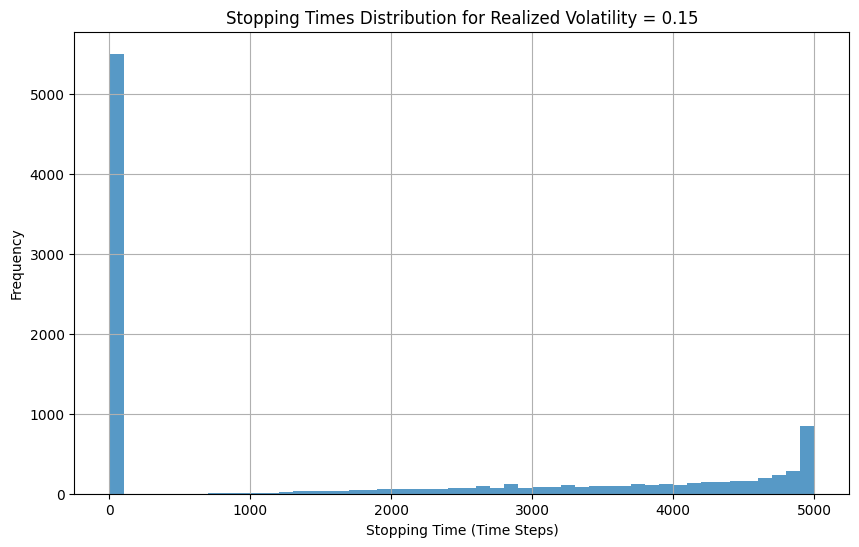

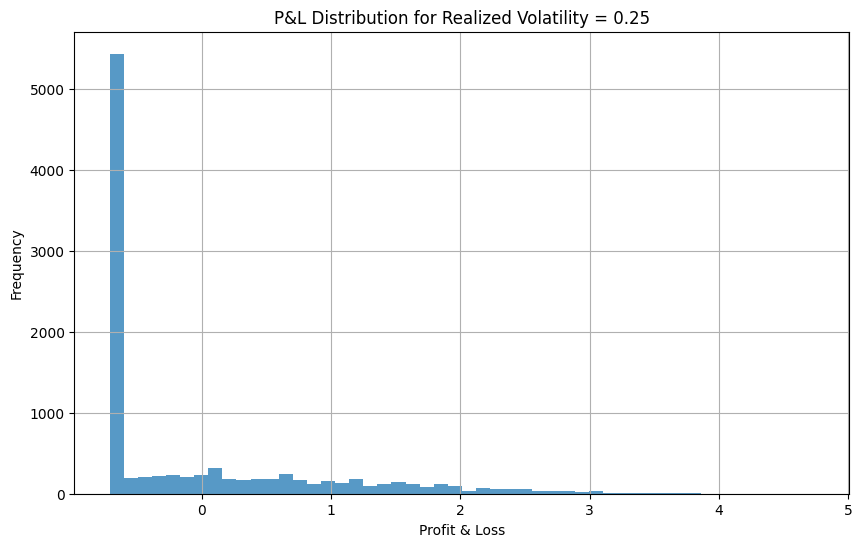

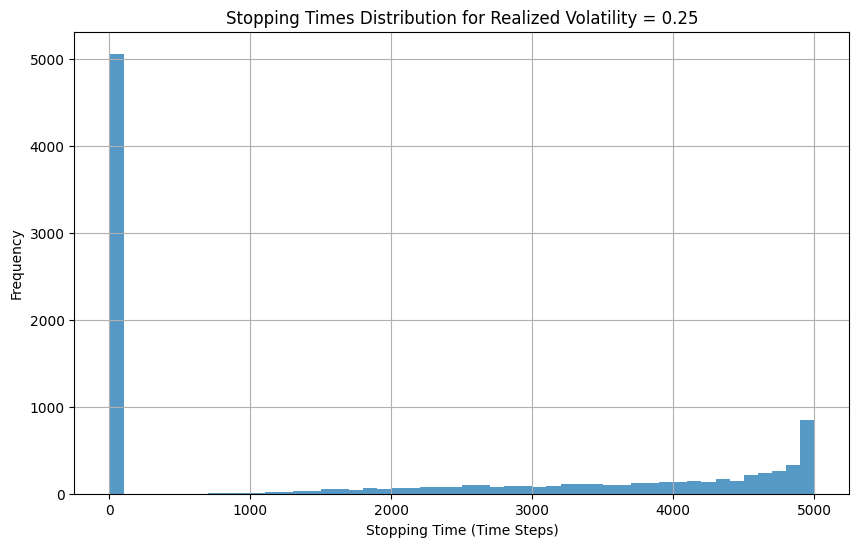

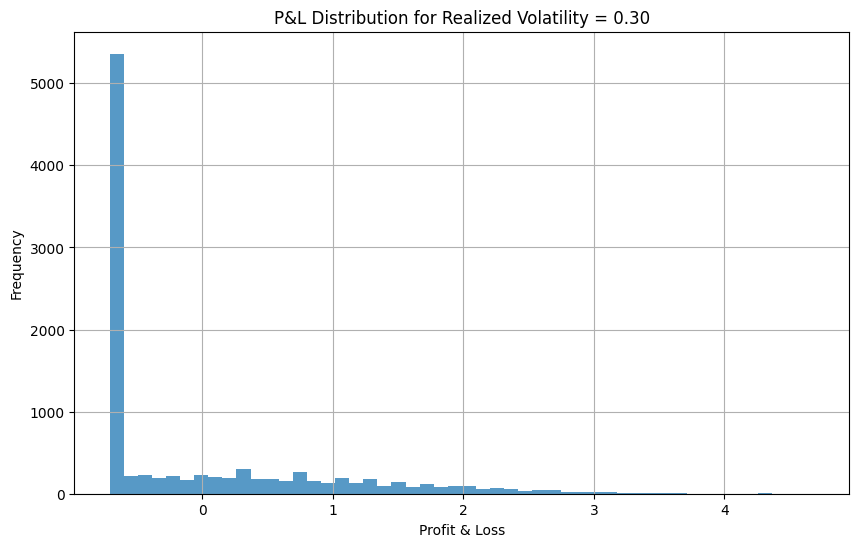

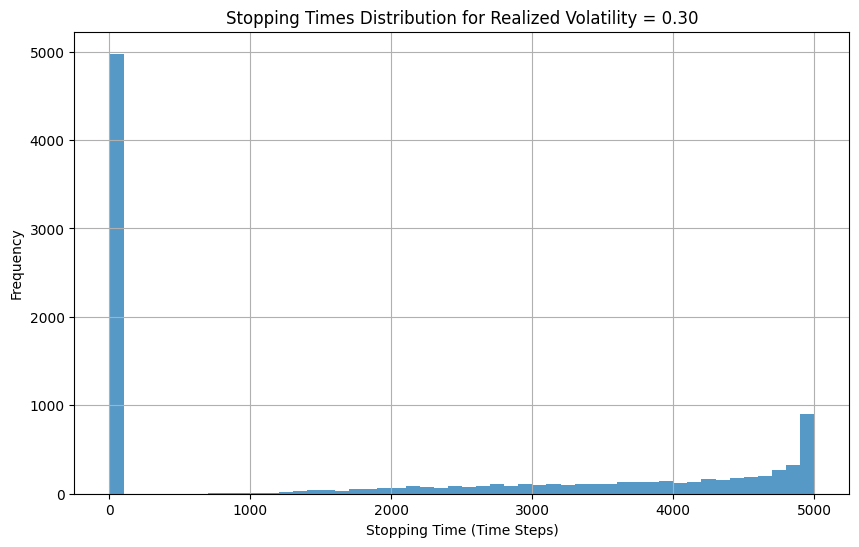

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
T = 1  # Time to maturity
K = 10  # Strike price
r = 0.02  # Risk-free rate
M = 10000  # Number of sample paths
N = 5000  # Number of time steps in the binomial tree
dt = float(T / N)  # Time step size
S0 = 10  # Initial stock price
p = 0.5  # Probability for upward movement

# Function to calculate P&L for each sampled path
def calculate_pnl(sampled_paths, K, r, T, N):
    pnl = np.zeros(M)  # Array to store P&L

    for i in range(M):
        # Calculate P&L at maturity
        pnl[i] = max(K - sampled_paths[N, i], 0) * np.exp(-r * T) - option_values[0, 0]

    return pnl

# Function to calculate stopping times using the proposed method
def calculate_stopping_times_proposed_method(sampled_paths, sampled_continuation_values, K, dt):
    stopping_times = np.full(M, T)  # Default stopping time is T (no early exercise)

    for i in range(M):
        early_exercise_values = np.maximum(K - sampled_paths[:, i], 0)  # Calculate early exercise values

        # Subtract continuation values and find the first positive occurrence
        difference = early_exercise_values - sampled_continuation_values[:, i]
        positive_indices = np.where(difference > 0)[0]  # Find where early exercise occurs

        # Ensure that there is at least one positive index for early exercise
        if len(positive_indices) > 0:
            stopping_time_index = float(positive_indices[0])  # The first time step where early exercise happens
            stopping_times[i] = stopping_time_index  # Convert index to actual time

    return stopping_times

# Function to sample valid paths through the binomial tree
def sample_binomial_tree_paths(stock_prices, continuation_value_matrix, M, N, p):
    sampled_paths = np.zeros((N + 1, M))
    sampled_continuation_values = np.zeros((N + 1, M))

    for i in range(M):  # For each sample path
        current_node = 0  # Start at the root (node 0 at step 0)
        for step in range(N + 1):
            # Record the stock price and continuation value at the current node
            sampled_paths[step, i] = stock_prices[step, current_node]
            sampled_continuation_values[step, i] = continuation_value_matrix[step, current_node]

            if step < N:
                # Randomly choose to go "up" or "down" at the next step using probability p
                move = np.random.choice([0, 1], p=[1-p, p])  # 0 = down, 1 = up
                current_node += move  # Move to the next node

    return sampled_paths, sampled_continuation_values

# Simulate paths with different realized volatilities
realized_volatilities = [0.15, 0.25, 0.30]  # Deviating volatilities

for realized_sigma in realized_volatilities:
    # Adjust the binomial tree to use the new volatility for each iteration
    u = np.exp(realized_sigma * np.sqrt(dt))  # Up factor
    d = 1 / u  # Down factor
    p_realized = (np.exp(r * dt) - d) / (u - d)  # Adjusted probability

    # Assuming stock_prices and continuation_value_matrix are calculated for each volatility
    sampled_paths_realized, sampled_continuation_values_realized = sample_binomial_tree_paths(
        stock_prices, continuation_value_matrix, M, N, p_realized)

    # Calculate P&L for the realized volatility
    pnl_realized = calculate_pnl(sampled_paths_realized, K, r, T, N)

    # Calculate stopping times for the realized volatility
    stopping_times_realized = calculate_stopping_times_proposed_method(
        sampled_paths_realized, sampled_continuation_values_realized, K, dt)

    # Plot the P&L distribution for realized volatility
    plt.figure(figsize=(10, 6))
    plt.hist(pnl_realized, bins=50, alpha=0.75)
    plt.title(f"P&L Distribution for Realized Volatility = {realized_sigma:.2f}")
    plt.xlabel("Profit & Loss")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

    # Plot the stopping times distribution for realized volatility
    plt.figure(figsize=(10, 6))
    plt.hist(stopping_times_realized, bins=50, alpha=0.75)
    plt.title(f"Stopping Times Distribution for Realized Volatility = {realized_sigma:.2f}")
    plt.xlabel("Stopping Time (Time Steps)")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()


In [ ]:
reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [ ]:
import pandas as pd
pd.DataFrame(path_early)